# Objective
The goal of this project is to analyze Rotten Tomatoes reviews and classify them as:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 positive

## Approach
The initial step will be to perform exploratory data analysis to get a better understanding of the data and use visuals to identify important factors. Then I will clean, and make the data more uniform to help our model capture the important factors which in return will help us develop a more precise and accurate model. After, I will train our model and finally evaluate its performance.

## About the data
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

Those interested can access the data [here](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data)

### Import Libraries

In [1]:
#from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os
import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
import tensorflow as tf
from transformers import TFAutoModel



### Load data

In [3]:
api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file(
        'sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')


100%|██████████| 1.28M/1.28M [00:00<00:00, 3.87MB/s]


100%|██████████| 494k/494k [00:00<00:00, 2.08MB/s]

# Exploratory Data Analysis

In [2]:
df = pd.read_csv('/kaggle/input/rottentomatoes/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df.shape

(156060, 4)

In [4]:
df.Sentiment.unique()

array([1, 2, 3, 4, 0])

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '1'),
  Text(3, 0, '4'),
  Text(4, 0, '0')])

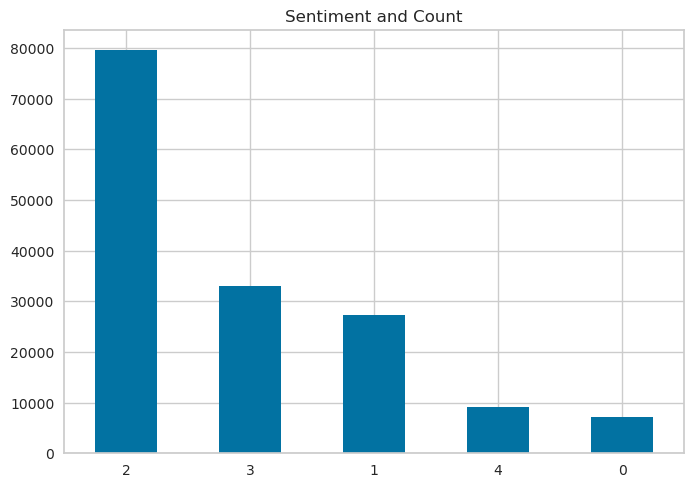

In [5]:
df['Sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment and Count")
plt.xticks(rotation=360)

### Missing Data

Text(0.5, 1.0, 'Missing Data')

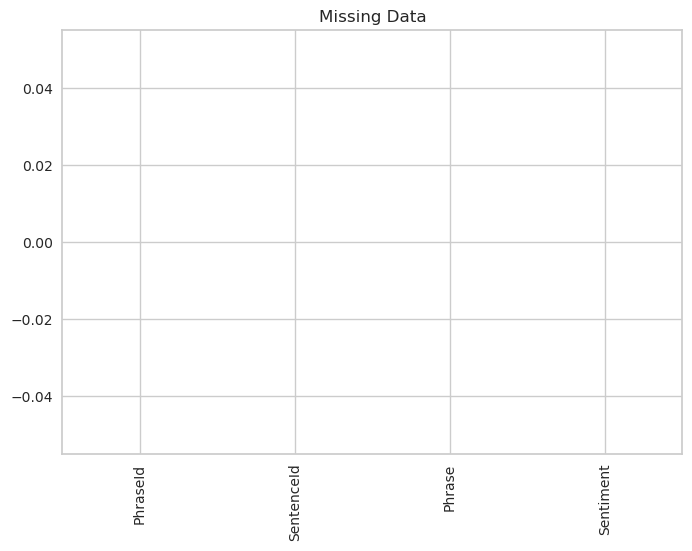

In [6]:
df.isna().sum().plot.bar()
plt.title('Missing Data')

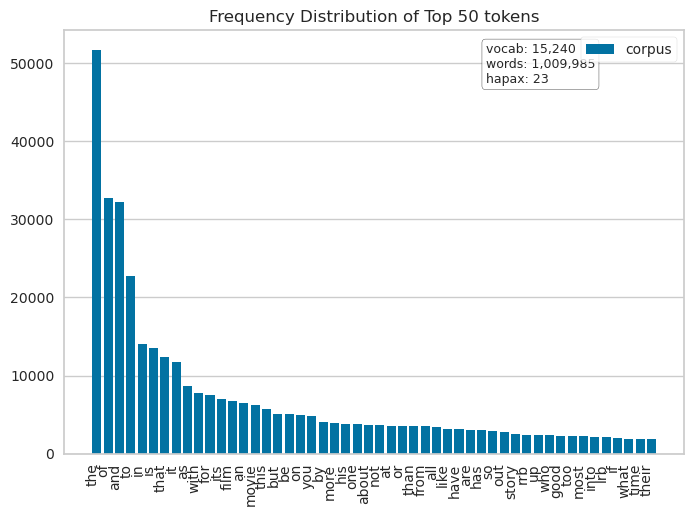

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [7]:
corpus = df["Phrase"]
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()


### Summary of EDA
- Our dataset is contains 4 columns and 156,060 reviews. 
- We have no missing data
- The `Sentiment` column contains the correct values and is of the correct data type.
- We have duplicates however our dataset is on the smaller size. Omitting those duplicates will decrease our dataset size to about 7,000 observations.
- Our `Phrase` column contains over 1 million words and the 3 most common words found in our reviews were `the`, `of` and `and`.
- There is also 23 words that appear once in our `Phrase` column

# Preprocessing 

## The concept of attention in ML
"
Think of an attention-based system consisting of three components:

- A process that “reads” raw data (such as source words in a source sentence), and converts them into distributed representations, with one feature vector associated with each word position. 
- A list of feature vectors storing the output of the reader. This can be understood as a “memory” containing a sequence of facts, which can be retrieved later, not necessarily in the same order, without having to visit all of them.
- A process that “exploits” the content of the memory to sequentially perform a task, at each time step having the ability put attention on the content of one memory element (or a few, with a different weight).
– Page 491, Deep Learning, 2017. "

What ends up happening is we create 3 matrices using our `Phrase` column and the `Sentiment` column. Using our `Phrase` column we will create two vectors containing <b>queries</b> and <b>keys</b>. These queries and keys is similar to a retrieval system. For example when we search for videos, the search engine will map your <b>query</b>(text in the search bar) againstt a set of <b>keys</b>(video title, description, etc) associated with canidate videos in the database, then present you with the best matched videos(<b>values</b>)

I will be using a pretrained bidirectional representaions from unlabeld text called BERT. Those that are interested in learning more about BERT and other huggingface pretrained model you can find more information on there [website](https://huggingface.co/docs/transformers/model_doc/bert). 


We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.

In [8]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len


(156060, 512)

We can no tokenize our `Phrase` column

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='tf')


In [10]:
tokens.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
tokens['input_ids'][:10]


<tf.Tensor: shape=(10, 512), dtype=int32, numpy=
array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 15107,  1103, ...,     0,     0,     0]], dtype=int32)>

In [12]:
tokens['attention_mask'][:10]


<tf.Tensor: shape=(10, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [13]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])


In [14]:
arr = df['Sentiment'].values


In [15]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape


(156060, 5)

In [16]:
labels[np.arange(num_samples), arr] = 1

labels


array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [17]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)


#### Summary
- Using our `Phrase` column we were able to create 2 tensor matrices which are numpy arrays but optimized to use CPU and GPU technology. 
- The `input_ids` array which is the observation id
- The other array `attention-mask` contains all the tokens (words) in our `Phrase` column should attend to and which should not. 
- Our last array `labels` contain the sentiment associated with the given observation


# Input Pipeline

In [18]:
with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

### Create a Tensor Dataset

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)


<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [20]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels


# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)


<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

#### Randomize & Batch Data

In [21]:
batch_size = 10

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)


<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(10, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(10, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(10, 5), dtype=tf.float64, name=None))>

#### Split data
We want a 90% train to 10% validation split.

In [23]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size


14045

In [24]:
# training dataset 
train_ds = dataset.take(size)
# validaton dataset
val_ds = dataset.skip(size)


### Save Dataset

In [25]:
tf.data.Dataset.save(train_ds, 'train')
tf.data.Dataset.save(val_ds, 'val')


In [26]:

train_ds.element_spec


({'input_ids': TensorSpec(shape=(10, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(10, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(10, 5), dtype=tf.float64, name=None))

In [27]:

val_ds.element_spec == train_ds.element_spec


True

In [28]:

ds = tf.data.Dataset.load('train', element_spec=train_ds.element_spec)


# Build & Train

#### LSTM
Now we need to define the frame around Bert, we need:

Two input layers (one for input IDs and one for attention mask).

A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

Max pooling layer to convert the 3D tensors output by Bert to 2D.

Final output activations using softmax for outputting categorical probabilities.

In [29]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
x = tf.keras.layers.BatchNormalization()(x)
# output
x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)


In [31]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [32]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])


In [36]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)


<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)


Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/3684780584.py", line 4, in <module>
      epochs=2
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1232, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/3684780584.py", line 4, in <module>
      epochs=2
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1232, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes at component 0: expected [16,512] but got [10,512].
	 [[{{node IteratorGetNext}}]]
	 [[model/bert/embeddings/assert_less/Assert/Assert/data_0/_20]]
  (1) INVALID_ARGUMENT:  Incompatible shapes at component 0: expected [16,512] but got [10,512].
	 [[{{node IteratorGetNext}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_30997]

In [ ]:
model.save('sentiment_model_lstm')


# Predict

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [39]:
probs = model.predict(prep_data("hello world"))[0]

probs

1/1 [==============================] - 4s 4s/step


array([0.21468994, 0.22653277, 0.19239807, 0.17194489, 0.19443433],
      dtype=float32)

In [40]:
np.argmax(probs)

1

# Evaluate

In [42]:
# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('/kaggle/input/rottentomatoes/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [43]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
63,64,2,"This quiet , introspective and entertaining independent is worth seeking .",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",1
116,117,4,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",3
156,157,5,Aggressive self-glorification and a manipulative whitewash .,1


In [44]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

1/1 [==============================] - 0s 369ms/step


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
63,64,2,"This quiet , introspective and entertaining independent is worth seeking .",1
81,82,3,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",1
116,117,4,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",1
156,157,5,Aggressive self-glorification and a manipulative whitewash .,1
